In [51]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os
from mtcnn import MTCNN
import base64
import requests
import json

In [49]:
def detect_humans(img_path, conf_threshold=0.5):
    model = YOLO('yolov8n.pt')
    results = model(img_path)
    img = cv2.imread(img_path)
    human_boxes = []
    for result in results:
        for box in result.boxes:
            cls = int(box.cls[0])
            conf = float(box.conf[0])
            #In COCO 0 -> person
            if cls == 0 and conf >conf_threshold:
                x1,y1,x2,y2 = map(int, box.xyxy[0])
                human_boxes.append((x1,y1,x2,y2))
                # cv2.rectangle(img, (x1,y1),(x2,y2), (0,255,0),2)
    return img, human_boxes

def detect_and_crop_faces(image, human_boxes, image_name):
    face_detector = MTCNN()
    face_boxes =[]
    face_id = 0

    h,w = image.shape[:2]
    for (x1,y1,x2,y2) in human_boxes:
        human_crop = image[y1:y2,x1:x2] # crop human region
        results = face_detector.detect_faces(human_crop)

        for res in results:
            if res and 'box' in res:
                x,y,fw,fh = res['box']
                fx1, fy1 = x1 + x, y1 + y 
                fx2, fy2 = fx1 + fw, fy1 +fh

                pad = 0.25
                dw, dh = int(fw * pad), int(fh * pad)
                cx1 = max(fx1 - dw, 0)
                cy1 = max(fy1 - dh, 0)
                cx2 = min(fx2 + dw, w)
                cy2 = min(fy2 + dh, h)

                face_crop = image[cy1:cy2, cx1:cx2]
                crop_name = f"{os.path.splitext(image_name)[0]}_face_{face_id}.jpg"
                cv2.imwrite(os.path.join('cropped_faces', crop_name), face_crop)

                # Show cropped face
                show_img(face_crop, f"{image_name} - Face {face_id}")
                face_id += 1
                

def show_img(img, title='Image'):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()



image 1/1 F:\skillovilla\assignment\Practice\AI eng Intern\images\1.jpg: 448x640 1 person, 68.6ms
Speed: 3.1ms preprocess, 68.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


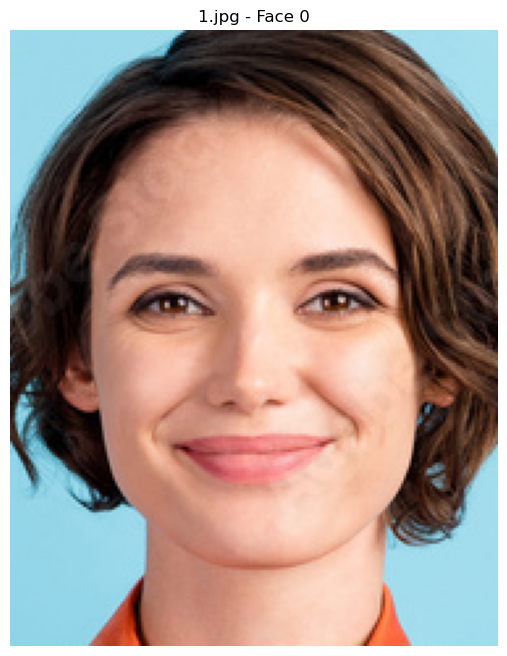


image 1/1 F:\skillovilla\assignment\Practice\AI eng Intern\images\2.jpg: 448x640 1 person, 70.1ms
Speed: 3.2ms preprocess, 70.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


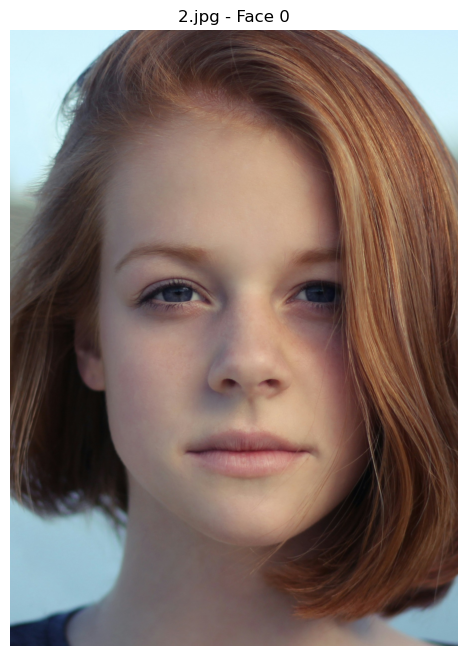


image 1/1 F:\skillovilla\assignment\Practice\AI eng Intern\images\3.jpg: 288x640 4 persons, 54.9ms
Speed: 2.2ms preprocess, 54.9ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


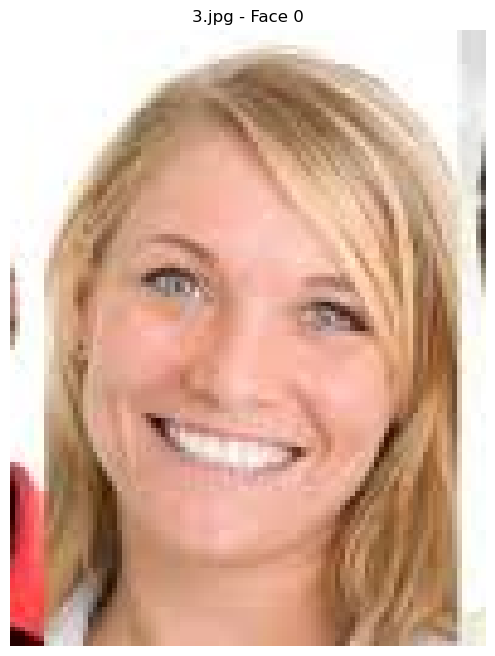

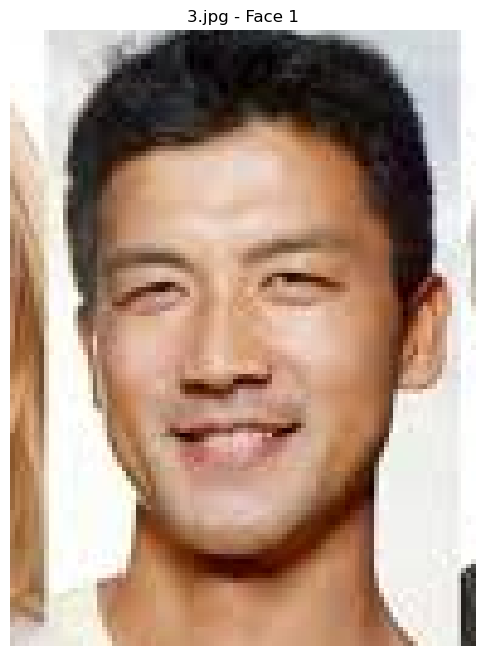


image 1/1 F:\skillovilla\assignment\Practice\AI eng Intern\images\4.jpg: 640x640 1 person, 92.1ms
Speed: 4.9ms preprocess, 92.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


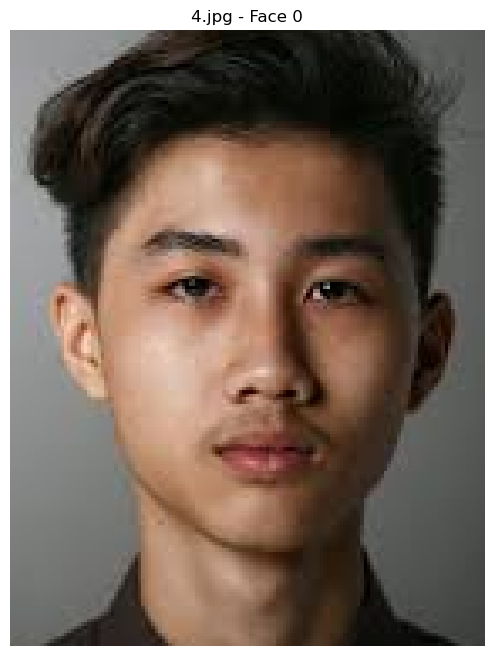


image 1/1 F:\skillovilla\assignment\Practice\AI eng Intern\images\5.jpg: 448x640 3 persons, 80.4ms
Speed: 3.2ms preprocess, 80.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


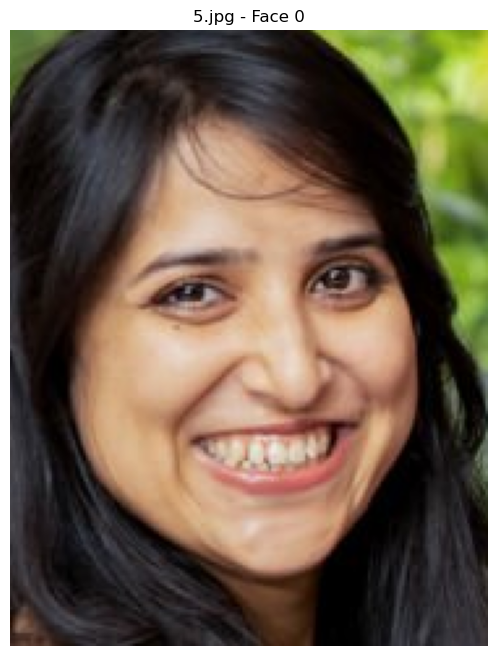

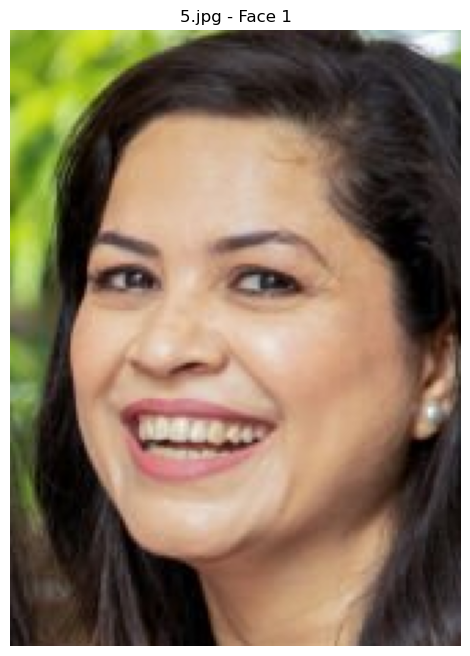

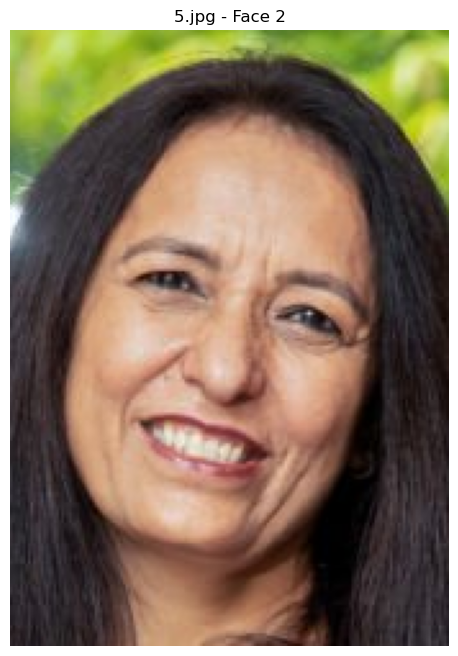


image 1/1 F:\skillovilla\assignment\Practice\AI eng Intern\images\6.jpg: 640x448 1 person, 52.3ms
Speed: 4.4ms preprocess, 52.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


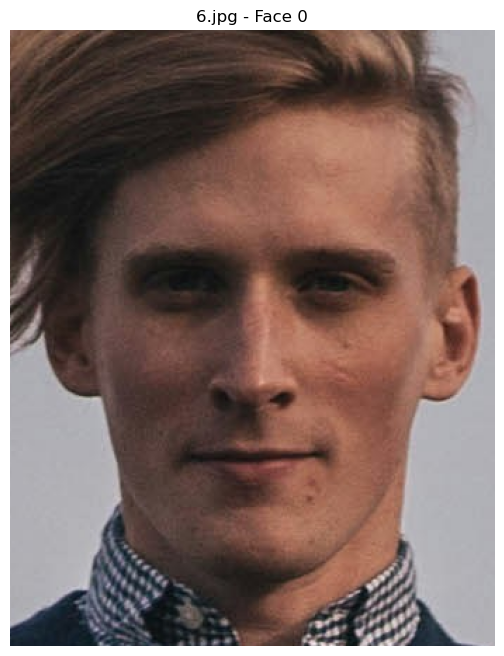


image 1/1 F:\skillovilla\assignment\Practice\AI eng Intern\images\7.jpg: 448x640 5 persons, 91.7ms
Speed: 7.5ms preprocess, 91.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


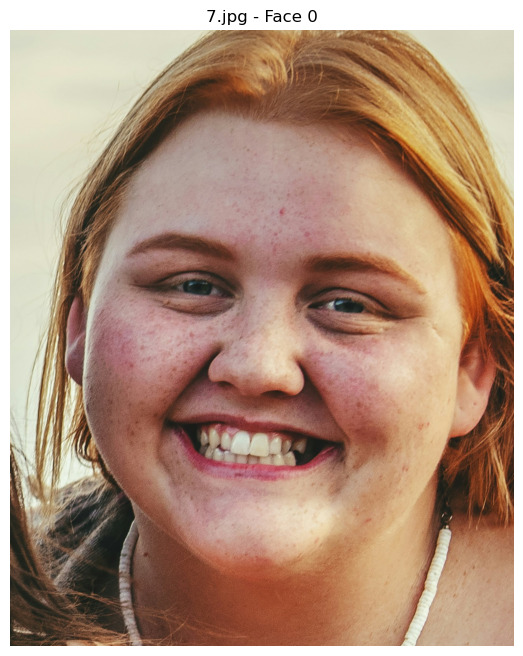

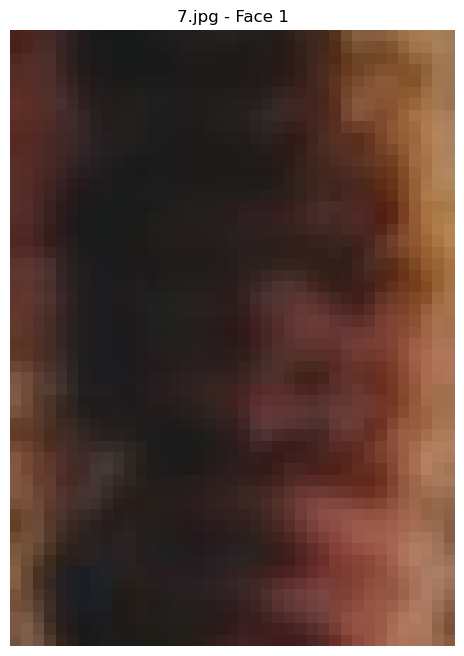

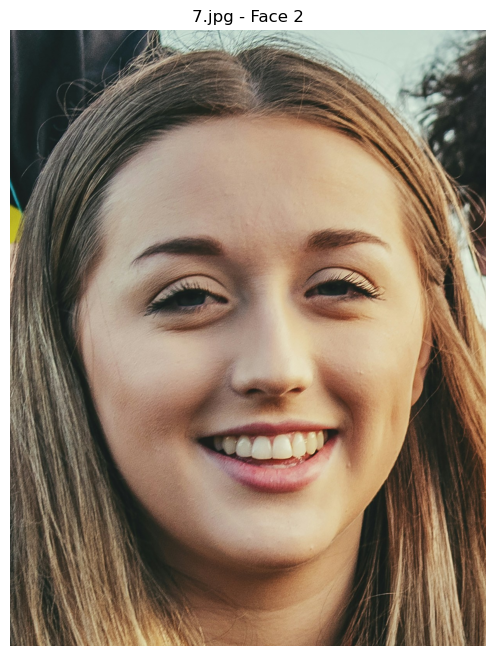

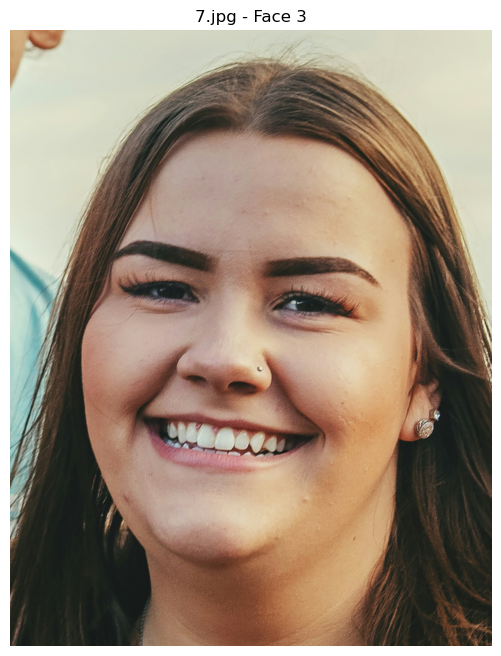

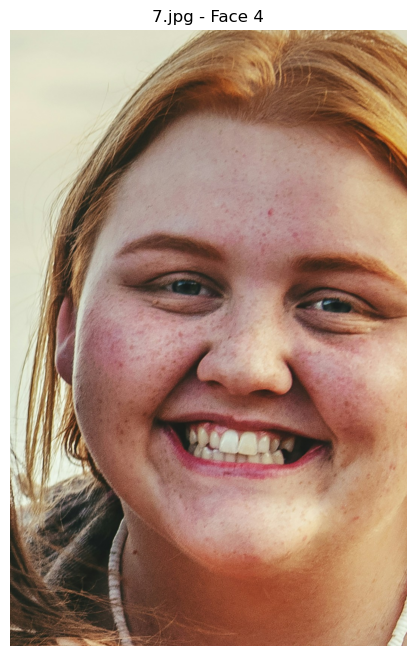

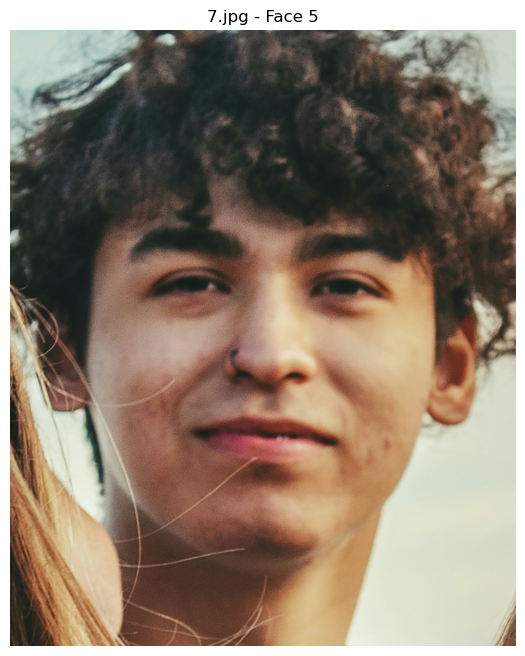

In [50]:
image_files = [f for f in os.listdir('images/') if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

for image_name in image_files:
    img_path = os.path.join(input_folder, image_name)

    img, human_boxes = detect_humans(img_path)
    detect_and_crop_faces(img, human_boxes, image_name)


In [83]:
API_KEY = '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'
OPENROUTER_API_URL = "https://openrouter.ai/api/v1/chat/completions"
VLM_MODEL = "anthropic/claude-3.5-sonnet"  # ✅ Correct (if available)


In [84]:
def image_attributes(image_path):
    prompt = (
        "Analyze the face in this image and return a JSON object with the following keys: "
        "gender, age_estimate, and skin_conditions (list of common issues: acne, redness, hyperpigmentation, baggy eyes, excessive       oiliness). "
        "Example format:\n"
        "{\n"
        "  \"gender\": \"Male\",\n"
        "  \"age_estimate\": \"25-30\",\n"
        "  \"skin_conditions\": [\"acne\", \"redness\", \"baggy eyes\"]\n"
        "}\n"
        "Only return the JSON."
    )
    with open(image_path, 'rb') as img_file:
        files = {'file':img_file}

        data = {
            "model": "openrouter/your-vlm-model",  # Replace with actual model name
            "messages": [
                {"role": "user", "content": prompt}
            ]
        }

        headers = {
            "Authorization": f"Bearer {API_KEY}"
        }
        response = requests.post(OPENROUTER_API_URL, headers=headers, data=data, files=files)
        return response.json()



In [85]:
def infer_all_faces(cropped_faces):
    results = {}
    for filename in os.listdir(cropped_faces):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(cropped_faces, filename)
            print(f"Processing: {filename}")
            attributes = image_attributes(image_path)
            results[filename] = attributes
    return results
results = infer_all_faces("cropped_faces/")
from pprint import pprint
pprint(results)

Processing: 1_face_0.jpg
Processing: 2_face_0.jpg
Processing: 3_face_0.jpg
Processing: 3_face_1.jpg
Processing: 4_face_0.jpg
Processing: 5_face_0.jpg
Processing: 5_face_1.jpg
Processing: 5_face_2.jpg
Processing: 6_face_0.jpg
Processing: 7_face_0.jpg
Processing: 7_face_1.jpg
Processing: 7_face_2.jpg
Processing: 7_face_3.jpg
Processing: 7_face_4.jpg
Processing: 7_face_5.jpg
{'1_face_0.jpg': {'error': {'code': 400,
                            'message': 'invalid content-type: '
                                       'multipart/form-data; '
                                       'boundary=f1a3a16a230a8fc0ac044a72f7308c4a'},
                  'user_id': 'user_30rBE5CCmaPNKPhx9bl0TBQtAE3'},
 '2_face_0.jpg': {'error': {'code': 400,
                            'message': 'invalid content-type: '
                                       'multipart/form-data; '
                                       'boundary=c1e1ba35210cee881d4e06228b37cb2b'},
                  'user_id': 'user_30rBE5CCmaPNKPhx9b

In [78]:
API_KEY = ''


In [91]:
import requests
import os
import base64

OPENROUTER_API_URL = "https://openrouter.ai/api/v1/chat/completions"
VLM_MODEL = "openai/gpt-4-vision-preview"
# API_KEY = "YOUR_API_KEY"  # Replace with your actual key

def image_attributes(image_path):
    prompt = (
        "Analyze the face in this image and return a JSON object with the following keys: "
        "gender, age_estimate, and skin_conditions (list of common issues: acne, redness, hyperpigmentation, baggy eyes, excessive oiliness). "
        "Example format:\n"
        "{\n"
        "  \"gender\": \"Male\",\n"
        "  \"age_estimate\": \"25-30\",\n"
        "  \"skin_conditions\": [\"acne\", \"redness\", \"baggy eyes\"]\n"
        "}\n"
        "Only return the JSON."
    )
    # Read and encode image
    with open(image_path, "rb") as img_file:
        img_bytes = img_file.read()
        img_b64 = base64.b64encode(img_bytes).decode("utf-8")
        img_markdown = f"![](data:image/jpeg;base64,{img_b64})"

    # Compose message with image and prompt
    messages = [
        {"role": "user", "content": f"{img_markdown}\n{prompt}"}
    ]

    data = {
        "model": VLM_MODEL,
        "messages": messages
    }

    headers = {
        "Authorization": f"Bearer {API_KEY}",
        "Content-Type": "application/json"
    }

    response = requests.post(OPENROUTER_API_URL, headers=headers, json=data)
    return response.json()

def infer_all_faces(cropped_faces):
    results = {}
    for filename in os.listdir(cropped_faces):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(cropped_faces, filename)
            print(f"Processing: {filename}")
            attributes = image_attributes(image_path)
            results[filename] = attributes
    return results

# Example usage:
results = infer_all_faces("cropped_faces/")
from pprint import pprint
pprint(results)

Processing: 1_face_0.jpg
Processing: 2_face_0.jpg
Processing: 3_face_0.jpg
Processing: 3_face_1.jpg
Processing: 4_face_0.jpg
Processing: 5_face_0.jpg
Processing: 5_face_1.jpg
Processing: 5_face_2.jpg
Processing: 6_face_0.jpg
Processing: 7_face_0.jpg
Processing: 7_face_1.jpg
Processing: 7_face_2.jpg
Processing: 7_face_3.jpg
Processing: 7_face_4.jpg
Processing: 7_face_5.jpg
{'1_face_0.jpg': {'error': {'code': 404,
                            'message': 'No endpoints found for '
                                       'openai/gpt-4-vision-preview.'},
                  'user_id': 'user_30rBE5CCmaPNKPhx9bl0TBQtAE3'},
 '2_face_0.jpg': {'error': {'code': 404,
                            'message': 'No endpoints found for '
                                       'openai/gpt-4-vision-preview.'},
                  'user_id': 'user_30rBE5CCmaPNKPhx9bl0TBQtAE3'},
 '3_face_0.jpg': {'error': {'code': 404,
                            'message': 'No endpoints found for '
                               